/Users/billy/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


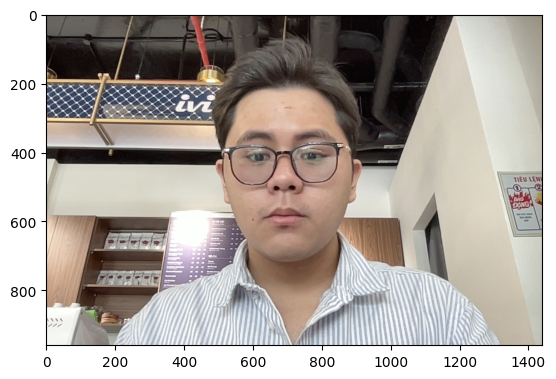

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
from PIL import Image

sample_image = Image.open('./sample/face.jpg')

plt.imshow(sample_image)

In [2]:
mtcnn = MTCNN(margin=32)
resnet = InceptionResnetV1(pretrained="vggface2").eval()


In [3]:
cropped_image = mtcnn(sample_image)
features = resnet(cropped_image.unsqueeze(0))
features

tensor([[ 0.0152,  0.0210, -0.0189,  0.0406,  0.0277, -0.0023,  0.0243, -0.0245,
          0.0267,  0.0525,  0.0442,  0.0164, -0.0776,  0.0069,  0.0244, -0.0091,
          0.0675,  0.0787, -0.0129,  0.0671,  0.0572, -0.0032,  0.0769, -0.0162,
         -0.0155, -0.0304,  0.0118, -0.0131, -0.0406,  0.0134,  0.0076,  0.0575,
         -0.0650,  0.0871,  0.0392, -0.0475,  0.0098, -0.0800, -0.0172,  0.0234,
          0.0096, -0.0366, -0.0807,  0.0199, -0.0112, -0.0072,  0.0210, -0.0200,
         -0.0205,  0.0335,  0.0173, -0.1042,  0.0557,  0.0632, -0.0075, -0.0849,
         -0.0923,  0.0544,  0.0024,  0.0461, -0.0292,  0.0215, -0.0284,  0.0599,
          0.0161, -0.0369, -0.0167, -0.0019,  0.0405, -0.0406, -0.0423, -0.0064,
         -0.0218,  0.0383,  0.0489,  0.0024,  0.0013,  0.0104,  0.0545, -0.0033,
          0.0469, -0.0204, -0.0334, -0.0623, -0.0062,  0.0607, -0.0155,  0.0102,
          0.0073,  0.0004, -0.0138,  0.0553, -0.0199, -0.0044,  0.0263,  0.0379,
          0.0149,  0.0715, -

In [4]:
import torch
torch.save(features, 'sample/output-features.pt')

input_features = torch.load("sample/output-features.pt")


taylor.jpeg ( 0 ,  0 )
face.jpg ( 0 ,  1 )
face2.jpg ( 0 ,  2 )
nguyen4.jpg ( 0 ,  3 )
ajlama.png ( 1 ,  0 )
tuanngoc.jpg ( 1 ,  1 )
nguyen2.jpg ( 1 ,  3 )
nguyen3.jpg ( 2 ,  0 )
nguyen1.jpg ( 2 ,  1 )
jbb.jpg ( 2 ,  2 )


<Figure size 640x480 with 0 Axes>

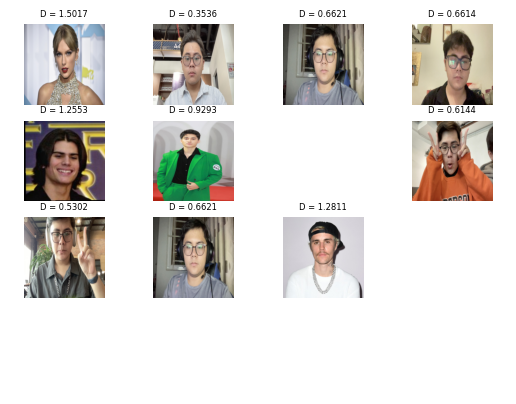

In [5]:
import torchvision.transforms as transformer

def open_and_compare(which: str):
  compare_image = Image.open(which)
  compare_image = transformer.Resize((480, 480))(compare_image)
  cropped_compare_image = mtcnn(compare_image)
  if cropped_compare_image is None:
    return torch.tensor(9999)
  
  compare_features = resnet(cropped_compare_image.unsqueeze(0))
  return (compare_features - input_features).norm(), compare_image
  
import os
items = os.listdir('./sample')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
f, axarr = plt.subplots(4,4)


for i in range(4):
  for j in range(4):
    axarr[i,j].axis("off")

cur_row = 0
for idx,file in enumerate(items):
  if file != "output-features.pt":
    print(file, "(", cur_row,", ", idx % 4, ")")
    output_norm, comparing_image = open_and_compare("./sample/{}".format(file))
    
    axarr[cur_row, idx % 4].axis('off')
    axarr[cur_row, idx % 4].imshow(comparing_image)
    axarr[cur_row, idx % 4].set_title(label='D = %.4f' % output_norm.item(), size=6)
    
    # print(" . ", output_norm)
    
    if idx > 0 and idx % 4 == 3:
      cur_row = cur_row + 1
    
    

# Implement and optimization
The implementation of this code will carefully split into two main parts. The first path represents a capture module and 
input into a datasets, stored at embedding features. The second part is a full pipeline.



In [6]:
import torch
import math
from facenet_pytorch import MTCNN, InceptionResnetV1

class FacenetPipeline(torch.nn.Module):
  
  def __init__(self, training: bool = False, detect_threshold: float = 0.76):
    super().__init__()
    
    # Switch back device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # First stage, detect image
    self.detect = MTCNN(margin=32, device=device)
    # Second stage, recognition
    self.recognition = InceptionResnetV1(pretrained="vggface2", device=device)
    self.detect_threshold = detect_threshold
    
    if training is None or training is False:
      self.recognition.eval()
  
  def forward(self, image):
    image, prob = self.detect(image, return_prob=True)
    
    if self.detect_threshold is not None and prob is not None and prob < self.detect_threshold:
      return None
    
    # If cannot found face
    if image is None:
      return None
    
    # Extract features
    image = self.recognition(image.unsqueeze(0))
    return image, prob

model = FacenetPipeline()

model

FacenetPipeline(
  (detect): MTCNN(
    (pnet): PNet(
      (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
      (prelu1): PReLU(num_parameters=10)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv2): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
      (prelu2): PReLU(num_parameters=16)
      (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
      (prelu3): PReLU(num_parameters=32)
      (conv4_1): Conv2d(32, 2, kernel_size=(1, 1), stride=(1, 1))
      (softmax4_1): Softmax(dim=1)
      (conv4_2): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    )
    (rnet): RNet(
      (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1))
      (prelu1): PReLU(num_parameters=28)
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
      (conv2): Conv2d(28, 48, kernel_size=(3, 3), stride=(1, 1))
      (prelu2): PReLU(num_parameters=48)
      (pool2): MaxPool2d(kernel_size=3, stride=2,

In [7]:
# Test
left, prob = model(sample_image)
print(left.shape)
(features - left).norm()

torch.Size([1, 512])


tensor(0., grad_fn=<LinalgVectorNormBackward0>)

In [8]:
# import numpy as np
# import cv2
# import os
# from pathlib import Path

# class Input():
  
#   def __init__(self, directory:str = "datasets"):
    
#     self.directory = Path(directory)
#     self.__ensure_dir__()
    
#   def __ensure_dir__(self):
#     # Check if the path exists or not
#     self.directory.mkdir(parents=True, exist_ok=True)

#   def __receive_username__(self):
#     label= input("Enter label name:")
#     return label
  
#   def __start_capture__(self):
    
#     model = FacenetPipeline()
    
#     vid = cv2.VideoCapture(0)
#     vid.set(cv2.CAP_PROP_FRAME_WIDTH, 480)  
#     vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

#     curr = 0
#     arr = []

#     while(True): 
        
#       # Capture the video frame 
#       # by frame 
#       ret, frame = vid.read() 
#       cv2.imshow('Capturing sample face for inference', frame) 
      
#       cropped_frame = cv2.resize(frame, (80, 80))
      
#       result = model(cropped_frame)
#       if result is not None:
#         image, _ = result
#         arr.append(image)
#         curr = curr + 1
      
#       if cv2.waitKey(1) & 0xFF == ord('q') or curr >= 10: 
#           break

#     # Release the video
#     vid.release() 
#     cv2.destroyAllWindows()
    
#     del model
#     return arr

#   def __serialize_tensor_to_file__(self, name: str, tensors: list[torch.Tensor]):
#     path = Path(os.path.join(self.directory.name, name))
    
#     # If not exists, make it
#     path.mkdir(parents=True, exist_ok=True)
    
#     for idx, tensor in enumerate(tensors):
#       filename = os.path.join(path.name, "{}.pt".format(idx))
#       torch.save(tensor, filename)
    

#   def append_label():
    
#     with open('labels.txt', "a") as f:
#       f.write("")
  
#   def start(self):
#     # Self username
#     username = self.__receive_username__()
#     arr = self.__start_capture__()
    
#     self.__serialize_tensor_to_file__(username, arr)
    
    
# input_thread  = Input()
# input_thread.start()
  